# Lecture 7 Python Fundamentals - Statistics & Optimization
## F&W ECOL 458: Environmental Data Science

**Learning Objectives:**
- Perform statistical analysis with SciPy
- Conduct hypothesis testing (t-tests, correlation)
- Understand and fit probability distributions
- Define cost functions and perform optimization

**Environment:** This notebook is designed to run on Google Colab.

---

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize, curve_fit

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Review: Descriptive Statistics with Pandas

Let's quickly review computing basic statistics before moving to inferential statistics.

In [2]:
# Sample environmental data: tree measurements from two forest types
np.random.seed(42)

# Simulate DBH measurements (cm) from two forest types
deciduous_dbh = np.random.normal(loc=35, scale=8, size=30)  # mean=35, std=8
coniferous_dbh = np.random.normal(loc=32, scale=10, size=25)  # mean=32, std=10

# Create DataFrame
trees_df = pd.DataFrame({
    'dbh_cm': np.concatenate([deciduous_dbh, coniferous_dbh]),
    'forest_type': ['Deciduous']*30 + ['Coniferous']*25
})

trees_df.head()

,dbh_cm,forest_type
0,38.973713,Deciduous
1,33.893886,Deciduous
2,40.181508,Deciduous
3,47.184239,Deciduous
4,33.126773,Deciduous


In [3]:
# Descriptive statistics by group
trees_df.groupby('forest_type')['dbh_cm'].describe()

,count,mean,std,min,25%,50%,75%,max
forest_type,,,,,,,,
Coniferous,25.0,30.110187,9.565682,12.403299,24.801558,30.843517,35.436183,50.522782
Deciduous,30.0,33.494825,7.200051,19.693758,30.271593,33.126839,37.882683,47.633703


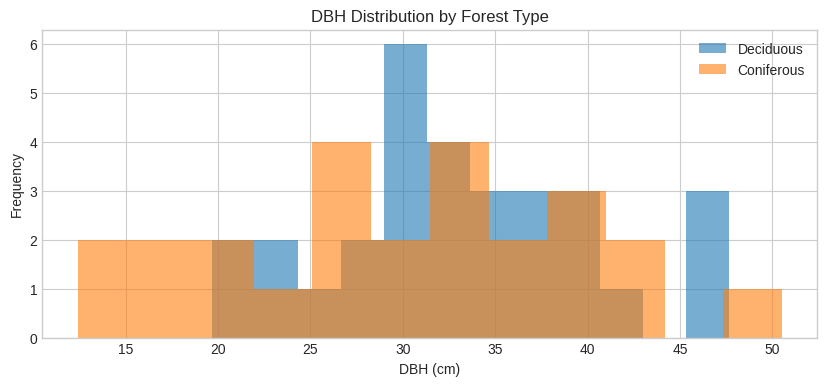

In [4]:
# Visualize the distributions
fig, ax = plt.subplots(figsize=(10, 4))

trees_df[trees_df['forest_type'] == 'Deciduous']['dbh_cm'].hist(
    alpha=0.6, label='Deciduous', bins=12, ax=ax)
trees_df[trees_df['forest_type'] == 'Coniferous']['dbh_cm'].hist(
    alpha=0.6, label='Coniferous', bins=12, ax=ax)

ax.set_xlabel('DBH (cm)')
ax.set_ylabel('Frequency')
ax.set_title('DBH Distribution by Forest Type')
ax.legend()
plt.show()

---
## 2. Introduction to SciPy Statistics

SciPy's `stats` module provides a comprehensive set of statistical functions including:
- Probability distributions
- Statistical tests
- Descriptive statistics

### 2.1 Working with Distributions

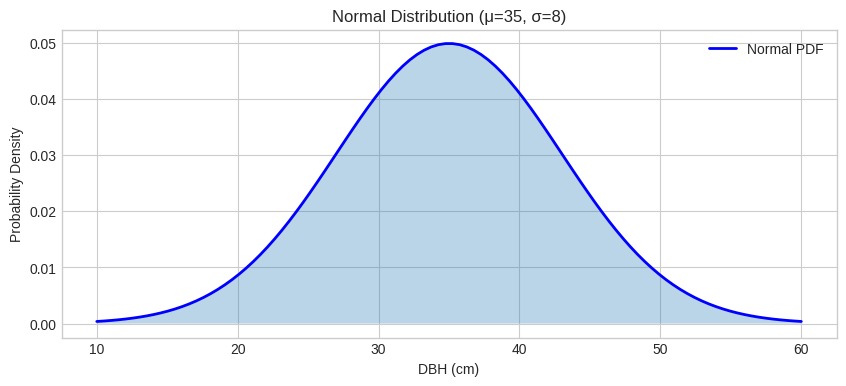

In [5]:
# Normal distribution
# Create a normal distribution with mean=35, std=8
normal_dist = stats.norm(loc=35, scale=8)

# PDF (Probability Density Function) - height of the curve
x = np.linspace(10, 60, 100)
pdf_values = normal_dist.pdf(x)

plt.figure(figsize=(10, 4))
plt.plot(x, pdf_values, 'b-', linewidth=2, label='Normal PDF')
plt.fill_between(x, pdf_values, alpha=0.3)
plt.xlabel('DBH (cm)')
plt.ylabel('Probability Density')
plt.title('Normal Distribution (μ=35, σ=8)')
plt.legend()
plt.show()

In [6]:
# CDF (Cumulative Distribution Function) - probability of being ≤ x
# What's the probability of finding a tree with DBH ≤ 30 cm?
prob_less_30 = normal_dist.cdf(30)
print(f"P(DBH ≤ 30) = {prob_less_30:.3f}")

# What's the probability of finding a tree with DBH between 30 and 40 cm?
prob_30_to_40 = normal_dist.cdf(40) - normal_dist.cdf(30)
print(f"P(30 < DBH ≤ 40) = {prob_30_to_40:.3f}")

P(DBH ≤ 30) = 0.266
P(30 < DBH ≤ 40) = 0.468


In [7]:
# PPF (Percent Point Function) - inverse of CDF
# What DBH value marks the 95th percentile?
dbh_95th = normal_dist.ppf(0.95)
print(f"95th percentile DBH: {dbh_95th:.1f} cm")

# What are the bounds for the middle 90% of trees?
lower = normal_dist.ppf(0.05)
upper = normal_dist.ppf(0.95)
print(f"Middle 90% range: {lower:.1f} to {upper:.1f} cm")

95th percentile DBH: 48.2 cm
Middle 90% range: 21.8 to 48.2 cm


In [8]:
# Generate random samples from a distribution
samples = normal_dist.rvs(size=1000)
print(f"Sample mean: {np.mean(samples):.2f}")
print(f"Sample std: {np.std(samples):.2f}")

Sample mean: 35.37
Sample std: 7.84


### 2.2 Fitting Distributions to Data

In [9]:
# Fit a normal distribution to our deciduous DBH data
deciduous_data = trees_df[trees_df['forest_type'] == 'Deciduous']['dbh_cm']

# Fit returns the parameters that best describe the data
mu, sigma = stats.norm.fit(deciduous_data)
print(f"Fitted parameters: μ = {mu:.2f}, σ = {sigma:.2f}")

Fitted parameters: μ = 33.49, σ = 7.08


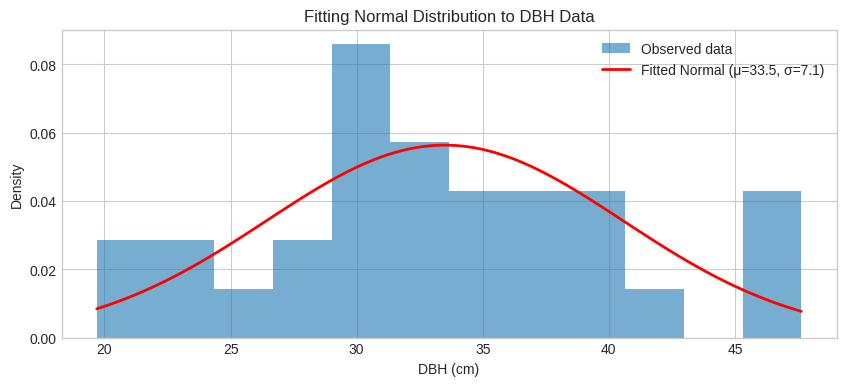

In [10]:
# Visualize the fit
fig, ax = plt.subplots(figsize=(10, 4))

# Histogram of actual data (normalized to show density)
ax.hist(deciduous_data, bins=12, density=True, alpha=0.6, label='Observed data')

# Fitted distribution
x = np.linspace(deciduous_data.min(), deciduous_data.max(), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2,
        label=f'Fitted Normal (μ={mu:.1f}, σ={sigma:.1f})')

ax.set_xlabel('DBH (cm)')
ax.set_ylabel('Density')
ax.set_title('Fitting Normal Distribution to DBH Data')
ax.legend()
plt.show()

---
## 3. Hypothesis Testing

Statistical tests help us make inferences about populations based on sample data.

### 3.1 One-Sample t-test

**Question:** Is the mean DBH of deciduous trees significantly different from 30 cm?

In [11]:
# One-sample t-test
# H0: μ = 30 cm
# H1: μ ≠ 30 cm

deciduous_data = trees_df[trees_df['forest_type'] == 'Deciduous']['dbh_cm']

t_stat, p_value = stats.ttest_1samp(deciduous_data, popmean=30)

print(f"Sample mean: {deciduous_data.mean():.2f} cm")
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Reject H0 (p < {alpha})")
    print("The mean DBH is significantly different from 30 cm.")
else:
    print(f"\nConclusion: Fail to reject H0 (p >= {alpha})")
    print("No significant difference from 30 cm.")

Sample mean: 33.49 cm
t-statistic: 2.659
p-value: 0.0126

Conclusion: Reject H0 (p < 0.05)
The mean DBH is significantly different from 30 cm.


### 3.2 Two-Sample t-test (Independent Samples)

**Question:** Is there a significant difference in mean DBH between deciduous and coniferous forests?

In [12]:
# Independent two-sample t-test
# H0: μ_deciduous = μ_coniferous
# H1: μ_deciduous ≠ μ_coniferous

deciduous_data = trees_df[trees_df['forest_type'] == 'Deciduous']['dbh_cm']
coniferous_data = trees_df[trees_df['forest_type'] == 'Coniferous']['dbh_cm']

t_stat, p_value = stats.ttest_ind(deciduous_data, coniferous_data)

print(f"Deciduous mean: {deciduous_data.mean():.2f} cm (n={len(deciduous_data)})")
print(f"Coniferous mean: {coniferous_data.mean():.2f} cm (n={len(coniferous_data)})")
print(f"\nt-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nConclusion: Significant difference between forest types (p < {alpha})")
else:
    print(f"\nConclusion: No significant difference between forest types (p >= {alpha})")

Deciduous mean: 33.49 cm (n=30)
Coniferous mean: 30.11 cm (n=25)

t-statistic: 1.496
p-value: 0.1406

Conclusion: No significant difference between forest types (p >= 0.05)


### 3.3 Correlation Analysis

**Question:** Is there a relationship between tree height and DBH?

In [13]:
# Create correlated height data
np.random.seed(42)
n = 50
dbh = np.random.uniform(15, 55, n)
# Height is correlated with DBH plus some noise
height = 0.5 * dbh + np.random.normal(0, 3, n) + 5

tree_measurements = pd.DataFrame({'dbh_cm': dbh, 'height_m': height})
tree_measurements.head()

,dbh_cm,height_m
0,29.981605,22.206202
1,53.028572,32.028391
2,44.279758,26.792934
3,38.946339,23.569859
4,21.240746,11.184807


In [14]:
# Pearson correlation coefficient
r, p_value = stats.pearsonr(tree_measurements['dbh_cm'],
                             tree_measurements['height_m'])

print(f"Pearson r: {r:.3f}")
print(f"p-value: {p_value:.6f}")

# Interpret the correlation
if abs(r) > 0.7:
    strength = "strong"
elif abs(r) > 0.4:
    strength = "moderate"
else:
    strength = "weak"

direction = "positive" if r > 0 else "negative"
print(f"\nInterpretation: {strength} {direction} correlation")

Pearson r: 0.897
p-value: 0.000000

Interpretation: strong positive correlation


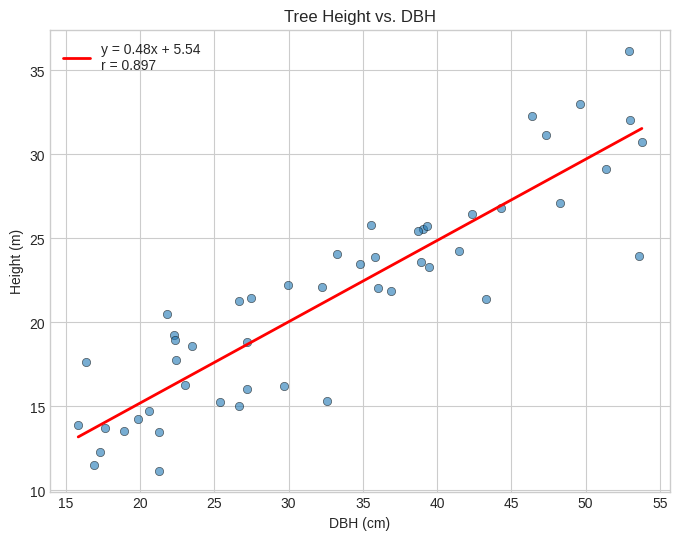

In [15]:
# Visualize the correlation
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(tree_measurements['dbh_cm'], tree_measurements['height_m'],
           alpha=0.6, edgecolors='black', linewidth=0.5)

# Add regression line
slope, intercept, r_val, p_val, std_err = stats.linregress(
    tree_measurements['dbh_cm'], tree_measurements['height_m'])

x_line = np.array([dbh.min(), dbh.max()])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'r-', linewidth=2,
        label=f'y = {slope:.2f}x + {intercept:.2f}\nr = {r:.3f}')

ax.set_xlabel('DBH (cm)')
ax.set_ylabel('Height (m)')
ax.set_title('Tree Height vs. DBH')
ax.legend()
plt.show()

### 3.4 Non-parametric Tests

When data doesn't meet normality assumptions, use non-parametric alternatives.

In [16]:
# Mann-Whitney U test (non-parametric alternative to t-test)
stat, p_value = stats.mannwhitneyu(deciduous_data, coniferous_data,
                                    alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.1f}")
print(f"p-value: {p_value:.4f}")

Mann-Whitney U statistic: 444.0
p-value: 0.2469


In [17]:
# Spearman correlation (rank-based, non-parametric)
rho, p_value = stats.spearmanr(tree_measurements['dbh_cm'],
                                tree_measurements['height_m'])

print(f"Spearman ρ: {rho:.3f}")
print(f"p-value: {p_value:.6f}")

Spearman ρ: 0.901
p-value: 0.000000


---
## 4. Introduction to Optimization

Optimization is about finding the best solution from a set of possible solutions. In environmental modeling, we often want to find parameter values that best fit our data.

### 4.1 What is a Cost Function?

A **cost function** (or objective function, loss function) measures how "wrong" our model is. We want to **minimize** this function.

Common cost functions:
- **Mean Squared Error (MSE)**: Average of squared differences
- **Root Mean Squared Error (RMSE)**: Square root of MSE
- **Mean Absolute Error (MAE)**: Average of absolute differences

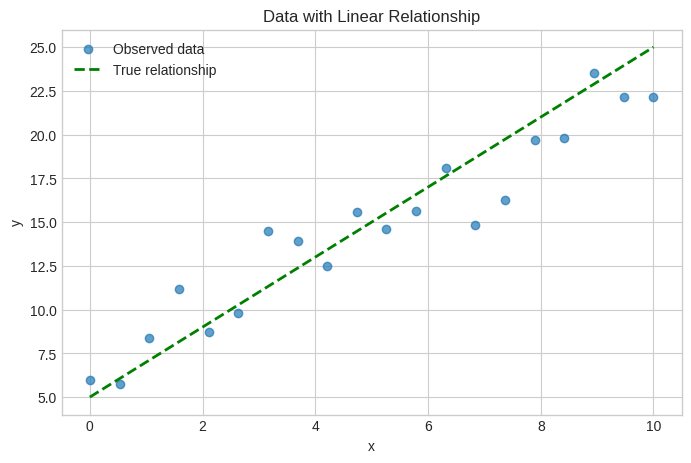

In [18]:
# Example: Fitting a line to data
# True relationship: y = 2x + 5 + noise
np.random.seed(42)
x_data = np.linspace(0, 10, 20)
y_true = 2 * x_data + 5
y_data = y_true + np.random.normal(0, 2, len(x_data))  # Add noise

plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, label='Observed data', alpha=0.7)
plt.plot(x_data, y_true, 'g--', label='True relationship', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data with Linear Relationship')
plt.legend()
plt.show()

In [19]:
# Define a cost function (Mean Squared Error)
def mse_cost(params, x, y_observed):
    """
    Calculate MSE for a linear model y = a*x + b

    Args:
        params: [a, b] - slope and intercept
        x: input data
        y_observed: observed y values

    Returns:
        Mean squared error
    """
    a, b = params
    y_predicted = a * x + b
    mse = np.mean((y_observed - y_predicted) ** 2)
    return mse

# Test with some parameter guesses
print(f"MSE with a=1, b=0: {mse_cost([1, 0], x_data, y_data):.2f}")
print(f"MSE with a=2, b=5: {mse_cost([2, 5], x_data, y_data):.2f}")
print(f"MSE with a=2, b=6: {mse_cost([2, 6], x_data, y_data):.2f}")

MSE with a=1, b=0: 99.01
MSE with a=2, b=5: 3.62
MSE with a=2, b=6: 5.30


### 4.2 Minimizing the Cost Function with `scipy.optimize.minimize`

In [20]:
# Use scipy.optimize.minimize to find the best parameters
from scipy.optimize import minimize

# Initial guess for parameters [a, b]
initial_guess = [0, 0]

# Minimize the cost function
result = minimize(
    fun=mse_cost,           # Function to minimize
    x0=initial_guess,       # Starting point
    args=(x_data, y_data),  # Additional arguments to pass to the function
    method='Nelder-Mead'    # Optimization algorithm
)

print("Optimization Result:")
print(f"  Success: {result.success}")
print(f"  Optimal parameters: a = {result.x[0]:.4f}, b = {result.x[1]:.4f}")
print(f"  Minimum MSE: {result.fun:.4f}")
print(f"  Iterations: {result.nit}")

Optimization Result:
  Success: True
  Optimal parameters: a = 1.6216, b = 6.5491
  Minimum MSE: 2.1838
  Iterations: 80


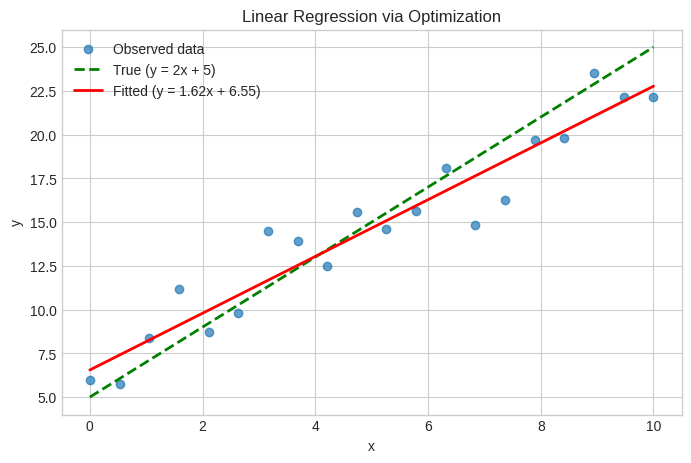

In [21]:
# Visualize the fitted line
a_opt, b_opt = result.x
y_fitted = a_opt * x_data + b_opt

plt.figure(figsize=(8, 5))
plt.scatter(x_data, y_data, label='Observed data', alpha=0.7)
plt.plot(x_data, y_true, 'g--', label='True (y = 2x + 5)', linewidth=2)
plt.plot(x_data, y_fitted, 'r-',
         label=f'Fitted (y = {a_opt:.2f}x + {b_opt:.2f})', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression via Optimization')
plt.legend()
plt.show()

### 4.3 Environmental Example: Fitting a Growth Curve

Many ecological processes follow non-linear relationships. Let's fit a **logistic growth curve** to population data:

$$N(t) = \frac{K}{1 + \left(\frac{K - N_0}{N_0}\right) e^{-rt}}$$

Where:
- $K$ = carrying capacity
- $r$ = growth rate
- $N_0$ = initial population

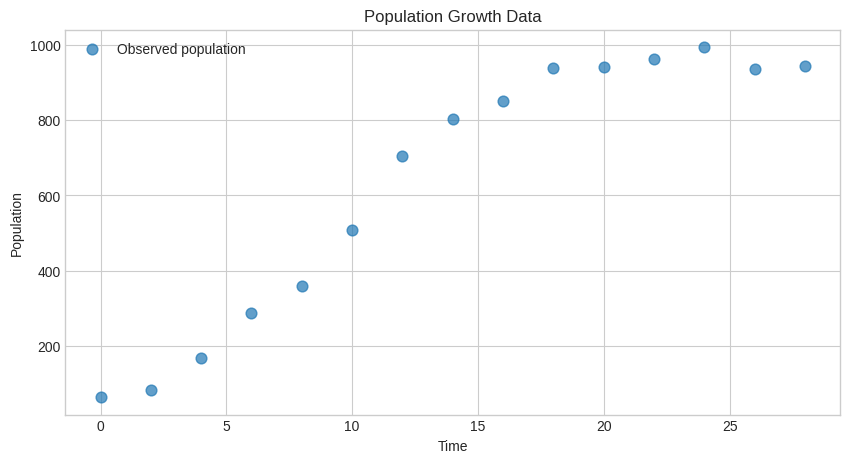

In [22]:
# Generate synthetic population data
np.random.seed(42)

# True parameters
K_true = 1000   # Carrying capacity
r_true = 0.3    # Growth rate
N0_true = 50    # Initial population

# Time points
t_data = np.arange(0, 30, 2)

# True logistic growth
def logistic_growth(t, K, r, N0):
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

# Generate data with noise
N_true = logistic_growth(t_data, K_true, r_true, N0_true)
N_observed = N_true + np.random.normal(0, 30, len(t_data))  # Add noise
N_observed = np.maximum(N_observed, 1)  # Ensure positive

plt.figure(figsize=(10, 5))
plt.scatter(t_data, N_observed, s=60, label='Observed population', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Growth Data')
plt.legend()
plt.show()

In [23]:
# Define cost function for logistic model
def logistic_cost(params, t, N_obs):
    K, r, N0 = params

    # Prevent invalid parameter values
    if K <= 0 or r <= 0 or N0 <= 0 or N0 >= K:
        return 1e10  # Return large value for invalid parameters

    N_pred = logistic_growth(t, K, r, N0)
    mse = np.mean((N_obs - N_pred) ** 2)
    return mse

# Initial guesses
initial_params = [500, 0.1, 20]  # [K, r, N0]

# Optimize
result = minimize(
    fun=logistic_cost,
    x0=initial_params,
    args=(t_data, N_observed),
    method='Nelder-Mead'
)

K_fit, r_fit, N0_fit = result.x

print("Fitted Parameters:")
print(f"  Carrying capacity (K): {K_fit:.1f} (true: {K_true})")
print(f"  Growth rate (r): {r_fit:.3f} (true: {r_true})")
print(f"  Initial population (N0): {N0_fit:.1f} (true: {N0_true})")
print(f"\n  Final MSE: {result.fun:.2f}")

Fitted Parameters:
  Carrying capacity (K): 972.0 (true: 1000)
  Growth rate (r): 0.313 (true: 0.3)
  Initial population (N0): 50.5 (true: 50)

  Final MSE: 505.23


In [ ]:
# Visualize the fit
t_smooth = np.linspace(0, 30, 100)
N_fitted = logistic_growth(t_smooth, K_fit, r_fit, N0_fit)
N_true_smooth = logistic_growth(t_smooth, K_true, r_true, N0_true)

plt.figure(figsize=(10, 6))
plt.scatter(t_data, N_observed, s=60, label='Observed data', zorder=5)
plt.plot(t_smooth, N_true_smooth, 'g--', linewidth=2, label='True model', alpha=0.7)
plt.plot(t_smooth, N_fitted, 'r-', linewidth=2, label='Fitted model')
plt.axhline(y=K_fit, color='gray', linestyle=':', label=f'Fitted K = {K_fit:.0f}')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Logistic Growth Model Fitting')
plt.legend()
plt.show()

### 4.4 Using `curve_fit` for Easier Fitting

SciPy provides `curve_fit` which is often more convenient for fitting models to data.

In [24]:
from scipy.optimize import curve_fit

# curve_fit expects function signature: f(x, param1, param2, ...)
# Our logistic_growth function already has this form!

# Provide initial guesses and bounds
p0 = [500, 0.1, 20]  # Initial guesses for [K, r, N0]
bounds = ([100, 0.01, 1], [2000, 1.0, 200])  # Lower and upper bounds

# Fit the model
popt, pcov = curve_fit(logistic_growth, t_data, N_observed, p0=p0, bounds=bounds)

# popt contains optimal parameters
# pcov is the covariance matrix (useful for uncertainty estimation)
K_cf, r_cf, N0_cf = popt

# Calculate standard errors from covariance matrix
perr = np.sqrt(np.diag(pcov))

print("curve_fit Results:")
print(f"  K = {K_cf:.1f} ± {perr[0]:.1f}")
print(f"  r = {r_cf:.3f} ± {perr[1]:.3f}")
print(f"  N0 = {N0_cf:.1f} ± {perr[2]:.1f}")

curve_fit Results:
  K = 972.0 ± 12.4
  r = 0.313 ± 0.017
  N0 = 50.5 ± 7.4


### 4.5 Optimization Methods

Different optimization algorithms are suited for different problems:

| Method | Use Case |
|--------|----------|
| `Nelder-Mead` | General purpose, no gradients needed |
| `BFGS` | Smooth functions, uses gradients |
| `L-BFGS-B` | Bounded optimization |
| `Powell` | Non-smooth functions |
| `differential_evolution` | Global optimization (avoids local minima) |

In [25]:
# Example with bounds using L-BFGS-B
from scipy.optimize import minimize

result_bounded = minimize(
    fun=logistic_cost,
    x0=[500, 0.1, 20],
    args=(t_data, N_observed),
    method='L-BFGS-B',
    bounds=[(100, 2000), (0.01, 1.0), (1, 200)]  # Bounds for each parameter
)

print(f"Bounded optimization result: {result_bounded.x}")

Bounded optimization result: [9.71972100e+02 3.12595622e-01 5.04762923e+01]


### 🔬 Quick Exercise

The **Michaelis-Menten equation** describes enzyme kinetics and nutrient uptake:

$$V = \frac{V_{max} \cdot S}{K_m + S}$$

Where:
- $V$ = reaction rate
- $V_{max}$ = maximum rate
- $S$ = substrate concentration
- $K_m$ = half-saturation constant

Fit this model to the data below to find $V_{max}$ and $K_m$.

In [ ]:
# Nutrient uptake data
substrate = np.array([0.5, 1, 2, 5, 10, 20, 50, 100])
rate = np.array([2.1, 3.8, 6.2, 10.5, 14.2, 17.1, 19.2, 19.8])

# Define the Michaelis-Menten function
def michaelis_menten(S, Vmax, Km):
    # Your code here
    pass

# Use curve_fit to find optimal parameters
# Your code here


---
## Summary

**Key concepts from today:**

1. **SciPy distributions**: `pdf`, `cdf`, `ppf`, `fit`, `rvs`
2. **Hypothesis testing**:
   - One-sample t-test: `stats.ttest_1samp()`
   - Two-sample t-test: `stats.ttest_ind()`
   - Correlation: `stats.pearsonr()`, `stats.spearmanr()`
3. **Optimization**:
   - Define a cost function that measures model error
   - Use `scipy.optimize.minimize()` to find optimal parameters
   - Use `scipy.optimize.curve_fit()` for convenient model fitting

**The optimization workflow:**
1. Define your model function
2. Define a cost function (e.g., MSE)
3. Choose initial parameter guesses
4. Call the optimizer
5. Evaluate and visualize results

---
## Solutions

Fitted Vmax: 20.91
Fitted Km: 4.73


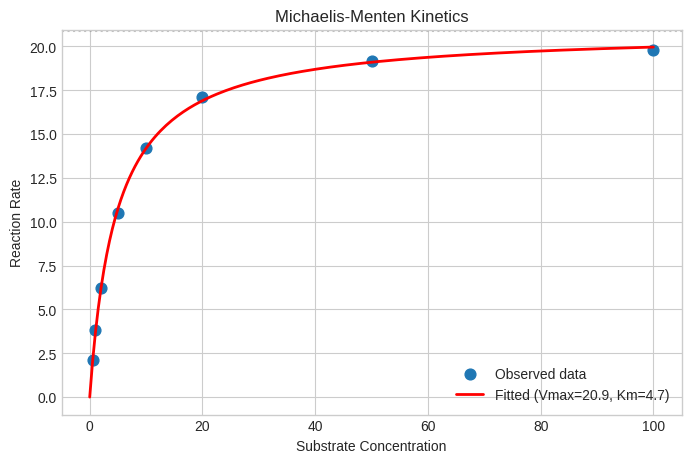

In [26]:
# Quick Exercise Solution: Michaelis-Menten fitting

substrate = np.array([0.5, 1, 2, 5, 10, 20, 50, 100])
rate = np.array([2.1, 3.8, 6.2, 10.5, 14.2, 17.1, 19.2, 19.8])

def michaelis_menten(S, Vmax, Km):
    return (Vmax * S) / (Km + S)

# Fit the model
popt, pcov = curve_fit(michaelis_menten, substrate, rate, p0=[20, 5])
Vmax_fit, Km_fit = popt

print(f"Fitted Vmax: {Vmax_fit:.2f}")
print(f"Fitted Km: {Km_fit:.2f}")

# Plot results
S_smooth = np.linspace(0, 100, 200)
V_fitted = michaelis_menten(S_smooth, Vmax_fit, Km_fit)

plt.figure(figsize=(8, 5))
plt.scatter(substrate, rate, s=60, label='Observed data')
plt.plot(S_smooth, V_fitted, 'r-', linewidth=2,
         label=f'Fitted (Vmax={Vmax_fit:.1f}, Km={Km_fit:.1f})')
plt.axhline(y=Vmax_fit, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Substrate Concentration')
plt.ylabel('Reaction Rate')
plt.title('Michaelis-Menten Kinetics')
plt.legend()
plt.show()